# PhageHostLearn - v3.4.klebsiella - training

An AI-based Phage-Host interaction predictor framework with K-loci and receptor-binding proteins at its core. This particular PhageHostLearn is for *Klebsiella pneumoniae* related phages. 

This notebook offers complete functionality to train a PhageHostLearn prediction model for Klebsiella phages starting from phage genomes, bacterial genomes and a matrix of known interactions.

**Overview of this notebook**
1. Initial set-up
2. Processing phage genomes and bacterial genomes into RBPs and K-locus proteins, respectively
3. Computing feature representations based on ESM-2
4. Training and evaluating the machine learning model

**Architecture of the PhageHostLearn framework**: 
- Multi-RBP setting: phages consisting of one or more RBPs (multi-instance)
- K-loci proteins (multi-instance) 
- Embeddings for both based on the ESM-2 language model
- An XGBoost model on top of the ESM-2 embeddings to make predictions

## 1. Initial set-up

PhageHostLearn takes as inputs phage genomes and bacterial genomes that are later transformed into phage RBPs and bacterial K-locus proteins. If you want to train a prediction model from scratch on phage and bacterial genomes, start from this step. If you want to reproduce our analyses from the processed RBPs and K-loci proteins in our Zenodo repository, go to `3. Feature construction`.

To do the data processing, you'll need to do the following:
1. Set up a folder for all the data that will be stored and generated by PhageHostLearn. Write the path to this folder in the code block below for 'general_path'.
2. In the folder, create two subfolders for the phage genomes and bacterial genomes (one for phage genomes and one for bacterial genomes). Collect both phage genomes and bacterial genomes as individual FASTA files and store them in the two separate folders.
3. Install [PHANOTATE](https://github.com/deprekate/PHANOTATE) and [Kaptive](https://github.com/katholt/Kaptive), both of which you'll need to process the phage and bacterial genomes. Locate PHANOTATE and write the path under the 2.1 code block below. Alternatively, copy the PHANOTATE file into your general folder. In addition, from the Kaptive repository, copy the .gbk databases into the general data folder.
4. Optionally install [bio_embeddings](https://github.com/sacdallago/bio_embeddings) to locally compute protein embeddings needed for RBP detection or opt do do this step in the cloud for faster results (see instructions below).
5. Install [fair-esm](https://github.com/facebookresearch/esm) to compute ESM-2 embeddings for the PhageHostLearn interaction prediction models.
6. Store the known interactions between phages and bacteria in an .xlsx file in which the first column is used for bacterial genome names and the first row is used for phage genome names. The names should correspond to the FASTA files in the respective folders.

In [1]:
general_path = '/Users/dimi/GoogleDrive/PhD/4_PHAGEHOST_LEARNING/42_DATA/Valencia_data'
data_suffix = 'Valencia'

## 2. Data processing

The data processing of PhageHostLearn consists of five consecutive steps: (1) phage gene calling with PHANOTATE, (2) phage protein embedding with bio_embeddings, (3) phage RBP detection, (4) bacterial genome processing with Kaptive and (5) processing the interaction matrix.

In [2]:
import phagehostlearn_processing as phlp

#### 2.1 PHANOTATE

In [ ]:
phage_genomes_path = general_path+'/phages_genomes'
phanotate_path = '/opt/homebrew/Caskroom/miniforge/base/envs/ML1/bin/phanotate.py'
phlp.phanotate_processing(general_path, phage_genomes_path, phanotate_path, data_suffix=data_suffix)

#### 2.2 Protein embeddings

The code block below computes protein embeddings for all of the detected phage genes (translated to proteins) using the bio_embeddings package (see `1. Initial set-up`). This might take a while on CPU. Alternatively, you can run this step in Google Colab or on Kaggle using the 'compute_embeddings_cloud.ipynb', which does exactly the same thing.

In [ ]:
phlp.compute_protein_embeddings(general_path, data_suffix=data_suffix)

#### 2.3 PhageRBPdetect

Either copy the `RBPdetect_phageRBPs.hmm` and `RBPdetect_xgb_hmm.json` files into the general data folder, or provide their absolute paths in the code block below, and then run the cell.

In [ ]:
pfam_path = general_path+'/RBPdetect_phageRBPs.hmm'
hmmer_path = '/Users/Dimi/hmmer-3.3.1'
xgb_path = general_path+'/RBPdetect_xgb_hmm.json'
gene_embeddings_path = general_path+'/phage_protein_embeddings'+data_suffix+'.csv'
phlp.phageRBPdetect(general_path, pfam_path, hmmer_path, xgb_path, gene_embeddings_path, data_suffix=data_suffix)

#### 2.4 Kaptive

In [4]:
bact_genomes_path = general_path+'/klebsiella_genomes/fasta_files'
kaptive_database_path = general_path+'/Klebsiella_k_locus_primary_reference.gbk'
phlp.process_bacterial_genomes(general_path, bact_genomes_path, kaptive_database_path, data_suffix=data_suffix)

  0%|          | 0/200 [00:00<?, ?it/s]

#### 2.5 Process the interaction matrix

In [35]:
interactions_xlsx_path = general_path+'/klebsiella_phage_host_interactions.xlsx'
phlp.process_interactions(general_path, interactions_xlsx_path, data_suffix=data_suffix)

If you want to combine separate data sources of interactions, you can use the code block below.

In [36]:
output = general_path+'/phage_host_interactions'+data_suffix
new_file = general_path+'/klebsiella_interactions_part2.xlsx' # part 2
phlp.add_to_database(output+'.csv', new_file, output)

## 3. Feature construction

Starts from the RBPbase.csv and the Locibase.json files that should be stored in the general_path. If you wish to reproduce our analyses, you can download these files from our [Zenodo repository](https://doi.org/10.5281/zenodo.8052911).

The last function outputs the ESM-2 feature matrix, labels, groups_loci and groups_phage (for evaluation). If the ESM-2 embeddings take too long, you might opt to do this step in the cloud or on a high-performance computer.

If you're retraining a model with the same data but new validated interactions, you can simply run the `construct_feature_matrices` function to construct updated feature matrices and labels and train models anew.

In [2]:
import phagehostlearn_features as phlf

In [ ]:
phlf.compute_esm2_embeddings_rbp(general_path, data_suffix=data_suffix)

In [7]:
phlf.compute_esm2_embeddings_loci(general_path, data_suffix=data_suffix)


 96%|█████████████████████████████████████▋ | 193/200 [2:13:34<04:11, 35.90s/it]


100%|███████████████████████████████████████| 200/200 [2:17:00<00:00, 41.10s/it]


In [3]:
rbp_embeddings_path = general_path+'/esm2_embeddings_rbp'+data_suffix+'.csv'
loci_embeddings_path = general_path+'/esm2_embeddings_loci'+data_suffix+'.csv'

In [4]:
features_esm2, labels, groups_loci, groups_phage = phlf.construct_feature_matrices(general_path, 
                                                                            data_suffix, loci_embeddings_path, 
                                                                            rbp_embeddings_path)

Dimensions match? True
Dimensions match? True


## 4. Training and evaluating models

In [5]:
import random
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import phagehostlearn_utils as phlu
import matplotlib.pyplot as plt
from matplotlib import cm
from joblib import dump, load
from tqdm.notebook import tqdm
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, LeaveOneGroupOut, GroupShuffleSplit, GroupKFold
from sklearn.metrics import roc_auc_score, auc, precision_recall_curve, roc_curve
%matplotlib inline

In [6]:
results_path = '/Users/dimi/GoogleDrive/PhD/4_PHAGEHOST_LEARNING/43_RESULTS/models'

#### 4.1 Training both models and saving them for later use

In [16]:
cpus=6
labels = np.asarray(labels)

In [13]:
# ESM-2 FEATURES + XGBoost model
imbalance = sum([1 for i in labels if i==1]) / sum([1 for i in labels if i==0])
xgb = XGBClassifier(scale_pos_weight=1/imbalance, learning_rate=0.3, n_estimators=250, max_depth=7,
                    n_jobs=cpus, eval_metric='logloss', use_label_encoder=False)
xgb.fit(features_esm2, labels)
xgb.save_model('phagehostlearn_esm2_xgb.json')

#### 4.2 LOGOCV with the combined model

In [ ]:
logo = LeaveOneGroupOut()
cpus = 6
scores_lan = []
label_list = []
labels = np.asarray(labels)
pbar = tqdm(total=len(set(groups_loci)))
for train_index, test_index in logo.split(features_esm2, labels, groups_loci):
    print(test_index)
    # get the training and test data
    Xlan_train, Xlan_test = features_esm2[train_index], features_esm2[test_index]
    y_train, y_test = labels[train_index], labels[test_index]
    imbalance = sum([1 for i in y_train if i==1]) / sum([1 for i in y_train if i==0])

    ## ESM-2 EMBEDDINGS: XGBoost model
    xgb = XGBClassifier(scale_pos_weight=1/imbalance, learning_rate=0.3, n_estimators=250, max_depth=7,
                        n_jobs=cpus, eval_metric='logloss', use_label_encoder=False)
    xgb.fit(Xlan_train, y_train)
    score_xgb = xgb.predict_proba(Xlan_test)[:,1]
    scores_lan.append(score_xgb)
    
    # save labels for later
    label_list.append(y_test)
    
    # pbar update
    pbar.update(1)
pbar.close()

In [ ]:
# save results
logo_results = {'labels': label_list, 'scores_language': scores_lan}   
with open(results_path+'/v3.4/combined_logocv_results_v34.pickle', 'wb') as f:
    pickle.dump(logo_results, f)

## 5. Results interpretation

In [7]:
# read results
with open(results_path+'/v3.4/combined_logocv_results_v34.pickle', 'rb') as f:
    logo_results = pickle.load(f)
scores_lan = logo_results['scores_language']
label_list = logo_results['labels']

# compute performance
rocaucs = []
praucs = []
rqueries_lan = []
random_guess = []
for i in range(len(set(groups_loci))):
    score_lan = scores_lan[i]
    y_test = label_list[i]
    try:
            roc_auc = roc_auc_score(y_test, score_lan)
            rocaucs.append(roc_auc)
            precision, recall, thresholds = precision_recall_curve(y_test, score_lan)
            praucs.append(round(auc(recall, precision), 3))
            ranked_lan = [x for _, x in sorted(zip(score_lan, y_test), reverse=True)]
            rqueries_lan.append(ranked_lan)
            random_guess.append(random.sample(ranked_lan, len(ranked_lan)))
    except:
        pass

#### ROC AUC curve

In [ ]:
# results, ROC AUC
for i in range(len(set(groups_loci))):
    score_lan = scores_lan[i]
    
labels = np.concatenate(label_list).ravel()
scoreslr = np.concatenate(scores_lan).ravel()

fig, ax = plt.subplots(figsize=(10,8))
fpr, tpr, thrs = roc_curve(labels, scoreslr)
rauclr = round(auc(fpr, tpr), 3)
ax.plot(fpr, tpr, c='#124559', linewidth=2.5, label='ESM-2 + XGBoost (AUC= '+str(rauclr)+')')
ax.set_xlabel('False positive rate', size=24)
ax.set_ylabel('True positive rate', size=24)
ax.legend(loc=4, prop={'size': 20})
ax.grid(True, linestyle=':')
ax.yaxis.set_tick_params(labelsize = 14)
ax.xaxis.set_tick_params(labelsize = 14)
fig.savefig(results_path+'/v3.4/logocv_rocauc.png', dpi=400)
fig.savefig(results_path+'/v3.4/logocv_rocauc_svg.svg', format='svg', dpi=400)

#### Hit ratio against microbiologist approach

In [10]:
import pandas as pd
import numpy as np
import json
import random

# prep the data
interactions1 = general_path+'/klebsiella_phage_host_interactions.xlsx'
interactions2 = general_path+'/klebsiella_interactions_part2.xlsx' # for part 1 NO SUGGESTIONS POSSIBLE -> ALL UNIQUE K-TYPES
matrix1 = pd.read_excel(interactions1, index_col=0, header=0)
matrix2 = pd.read_excel(interactions2, index_col=0, header=0)
locipath = general_path+'/LocibaseValencia.json'
seros = pd.read_csv(general_path+'/serotypesValencia.csv')
with open(locipath) as f:
    locibase = json.load(f)

# do the informed approach
hits = {i: 0 for i in range(1, 51)}
total = 0
# --------------------
# MATRIX 1
# --------------------
loci_serotype = {}
for i, accession in enumerate(locibase.keys()):
    loci_serotype[accession] = seros['sero'][i]
    
# phages sorted by broad-spec
sorted_phages = matrix1.sum().sort_values(ascending=False).index.tolist()

# delete keys not in this matrix (only suggestions within the matrix)
rownames = list(matrix1.index.values)
no_genome = ['K2', 'K21', 'K23', 'K27', 'K28', 'K40', 'K45', 'K48', 'K52', 'K53', 'K67', 'K69', 'K70', 'K71', 'K72']
rownames = [str(i) for i in rownames if i not in no_genome]
for key in list(loci_serotype.keys()):
    if key not in rownames:
        del loci_serotype[key]
        
# iterate over all accessions in matrix1
for i, accession in enumerate(rownames):
    # only compute hit ratio when we can find something
    if sum(matrix1.loc[accession]) > 0:
        # get the serotype
        serotype = loci_serotype[str(accession)]
        # search other bacteria with the same serotype
        same_serotype = [key for key, value in loci_serotype.items() if value == serotype]
        same_serotype.remove(str(accession))
        # get phage suggestions: columnnames of corresponding bacteria in matrix1 with value = 1
        phage_suggestions = []
        for j, acc in enumerate(same_serotype):
            if acc in ['132', '779', '806', '228', '245', '406', '1210', '1446', '1468', '1572', '2164']:
                acc = int(acc)
            colnames = matrix1.columns[matrix1.loc[acc] == 1].tolist()
            phage_suggestions.append(colnames)
        # flatten the list
        phage_suggestions = list(set([item for sublist in phage_suggestions for item in sublist]))
        # sort the list based: most narrow phages first!
        phage_suggestions.sort(key=lambda x: matrix1[x].sum(), reverse=True)
        
        total += 1
        for k in range(1, 51):
            # approach 1: if we dont have enough suggestions, pick extra at random from total pool available
            # approach 2: now, we supplement them with the sorted phages by broad-spectrum, not random!
            if k > len(phage_suggestions):
                sample_pool = [sugg for sugg in sorted_phages if sugg not in phage_suggestions]
                to_pick = k-len(phage_suggestions)
                if len(sample_pool) < to_pick:
                    phage_suggestions = phage_suggestions + sample_pool
                else:
                    phage_suggestions = phage_suggestions + sample_pool[:to_pick]

            #suggested = random.sample(phage_suggestions, k)
            if any([matrix1.loc[accession, sugg] == 1 for sugg in phage_suggestions]):
                hits[k] += 1
                
# --------------------
# MATRIX 2
# --------------------
hits2 = {i: 0 for i in range(1, 51)}
total2 = 0
loci_serotype = {}
for i, accession in enumerate(locibase.keys()):
    loci_serotype[accession] = seros['sero'][i]
    
sorted_phages = matrix2.sum().sort_values(ascending=False).index.tolist()

# delete keys not in this matrix (only suggestions within the matrix)
rownames = list(matrix2.index.values)
rownames = [str(i) for i in rownames]
for key in list(loci_serotype.keys()):
    if key not in rownames:
        del loci_serotype[key]

# iterate over all accessions in matrix2
for i, accession in enumerate(matrix2.index.values):
    # only compute hit ratio when we can find something
    if sum(matrix2.loc[accession]) > 0:
        # get the serotype
        serotype = loci_serotype[str(accession)]
        # search other bacteria with the same serotype
        same_serotype = [key for key, value in loci_serotype.items() if value == serotype]
        same_serotype.remove(str(accession))
        # get phage suggestions: columnnames of corresponding bacteria in matrix2 with value = 1
        phage_suggestions = []
        for j, acc in enumerate(same_serotype):
            if acc in ['132', '779', '806', '228', '245', '406', '1210', '1446', '1468', '1572', '2164']:
                acc = int(acc)
            colnames = matrix2.columns[matrix2.loc[acc] == 1].tolist()
            phage_suggestions.append(colnames)
        # flatten the list
        phage_suggestions = list(set([item for sublist in phage_suggestions for item in sublist]))
        # sort the list based: most narrow phages first!
        phage_suggestions.sort(key=lambda x: matrix2[x].sum(), reverse=True)

        total += 1
        total2 += 1
        for k in range(1, 51):
            # if we dont have enough suggestions, pick extra at random from the total pool
            if k > len(phage_suggestions):
                sample_pool = [sugg for sugg in sorted_phages if sugg not in phage_suggestions]
                to_pick = k-len(phage_suggestions)
                if len(sample_pool) < to_pick:
                    phage_suggestions = phage_suggestions + sample_pool
                else:
                    phage_suggestions = phage_suggestions + sample_pool[:to_pick]
            
            if any([matrix2.loc[accession, sugg] == 1 for sugg in phage_suggestions]):
                hits[k] += 1
                hits2[k] += 1

informed_hitratio = {k: v/total for k, v in hits.items()}
informed_hitratio2 = {k: v/total2 for k, v in hits2.items()}

In [ ]:
# results, hit ratios @ K
ks = np.linspace(1, 50, 50)
hits_lan = [phlu.hitratio(rqueries_lan, int(k)) for k in ks]
hits_random = [phlu.hitratio(random_guess, int(k)) for k in ks]
fig, ax = plt.subplots(figsize=(10,8))
ax.plot(ks, hits_lan, c='#124559', linewidth=2.5, label='ESM-2 + XGBoost')
#ax.plot(ks, hits_ens, c='#124559', linewidth=2.5, label='Combined model')
#ax.plot(ks, hits_random, c='#81B29A', linewidth=2.5, ls=':', label='Random guess')
ax.plot(ks, list(informed_hitratio.values()), c='#E15554', linewidth=2.5, ls='-.', label='Informed microbiologist')
#ax.plot(ks, list(informed_hitratio2.values()), c='#E15554', linewidth=2.5, ls=':', label='Informed guess (Bea only)')
ax.set_xlabel('$\it{k}$', size=24)
ax.set_ylabel('Hit ratio @ $\it{k}$', size=24)
ax.set_ylim(0.1, 1)
ax.legend(loc=4, prop={'size': 24})
ax.grid(True, linestyle=':')
ax.yaxis.set_tick_params(labelsize = 14)
ax.xaxis.set_tick_params(labelsize = 14)
fig.savefig(results_path+'/v3.4/logocv_hitratio_informed.png', dpi=400)
fig.savefig(results_path+'/v3.4/logocv_hitratio_informed_svg.svg', format='svg', dpi=400)

#### Performance per K-type

https://medium.com/@curryrowan/simplified-logistic-regression-classification-with-categorical-variables-in-python-1ce50c4b137

In [8]:
# read results
with open(results_path+'/v3.4/combined_logocv_results_v34.pickle', 'rb') as f:
    logo_results = pickle.load(f)
scores_lan = logo_results['scores_language']
scores_hdc = logo_results['scores_hdc']
label_list = logo_results['labels']

# read K-types
seros = pd.read_csv(general_path+'/serotypesValencia.csv')

In [9]:
# mean hit ratio per K-type
unique_seros = list(set(seros['sero']))
performance_ktypes = {}
labelcount_ktypes = {}
for unique in unique_seros:
    indices = seros['sero'] == unique
    subscores_lan = [val for is_good, val in zip(indices, scores_lan) if is_good]
    subscores_hdc = [val for is_good, val in zip(indices, scores_hdc) if is_good]
    sublabels = [val for is_good, val in zip(indices, label_list) if is_good]
    labelcount_ktypes[unique] = [sum(i) for i in sublabels]
    rqueries_lan = []
    rqueries_hdc = []
    rqueries_ens = []
    for i in range(len(subscores_lan)):
        score_lan = subscores_lan[i]
        score_hdc = subscores_hdc[i]
        score_ens = [phlu.uninorm(score_lan[j], score_hdc[j]) for j in range(len(score_lan))]
        y_test = sublabels[i]
        if sum(y_test) > 0:
            ranked_lan = [x for _, x in sorted(zip(score_lan, y_test), reverse=True)]
            ranked_hdc = [x for _, x in sorted(zip(score_hdc, y_test), reverse=True)]
            ranked_ens = [x for _, x in sorted(zip(score_ens, y_test), reverse=True)]
            rqueries_lan.append(ranked_lan)
            rqueries_hdc.append(ranked_hdc)
            rqueries_ens.append(ranked_ens)
    if len(rqueries_lan) > 0:
        hr_lan = round(phlu.hitratio(rqueries_lan, 10), 3)
        hr_hdc = round(phlu.hitratio(rqueries_hdc, 10), 3)
        hr_ens = round(phlu.hitratio(rqueries_ens, 10), 3)
        performance_ktypes[unique] = [('HR_XGB', hr_lan), ('HR_HDC', hr_hdc), ('HR_COMBINED', hr_ens)]
    #else:
    #    performance_ktypes[unique] = [('MAR_XGB', np.nan), ('MAR_HDC', np.nan), ('MAR_COMBINED', np.nan)]

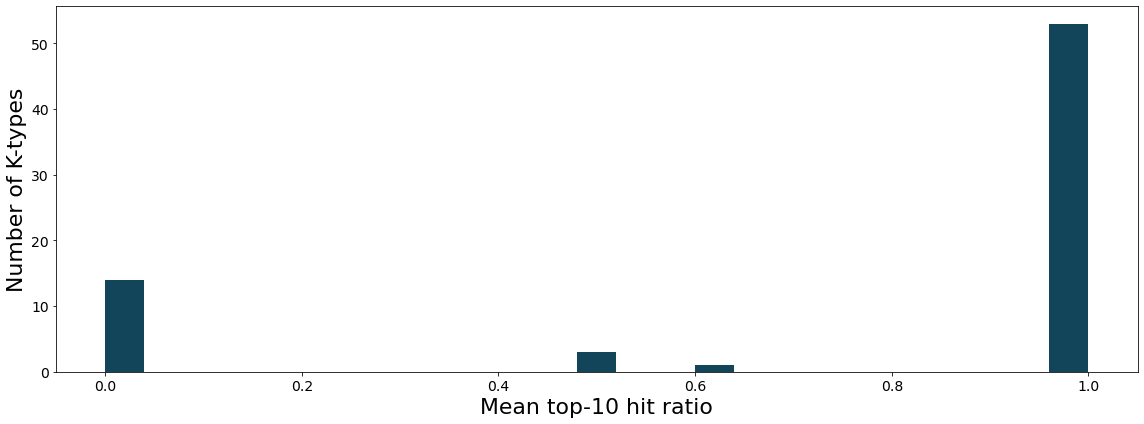

In [17]:
performance_hr_xgb = []
for ktype in performance_ktypes:
    performance_hr_xgb.append(performance_ktypes[ktype][0][1])
sortedpairs = [(x,y) for y, x in sorted(zip(performance_hr_xgb, list(performance_ktypes.keys())), reverse=True)]
fig, ax = plt.subplots(figsize=(16,6))
ax.hist(performance_hr_xgb, bins=25, color='#124559')
#sns.barplot(x=[score for (key, score) in sortedpairs], y=[key for (key, score) in sortedpairs], ax=ax, palette='magma')
ax.set_xlabel('Mean top-10 hit ratio', size=22)
ax.set_ylabel('Number of K-types', size=22)
ax.yaxis.set_tick_params(labelsize = 14)
ax.xaxis.set_tick_params(labelsize = 14)
fig.tight_layout()
fig.savefig(results_path+'/v3.4/histogram_ktypes_svg.svg', format='svg', dpi=400)

#### Hit ratio per K-type versus number of pos labels

In [23]:
top10 = [x[0] for x in sortedpairs if x[1] == 1] # all with HR == 1
bottom10 = [x[0] for x in sortedpairs if x[1] == 0] # all with HR == 0
middle = [x[0] for x in sortedpairs if (x[1] != 0 and x[1] != 1)]
countst10 = []
countsb10 = []
countsmid = []
for key in labelcount_ktypes.keys():
    if key in top10:
        countst10.append(labelcount_ktypes[key])
    elif key in bottom10:
        countsb10.append(labelcount_ktypes[key])
    elif key in middle:
        countsmid.append(labelcount_ktypes[key])
countst10 = [i for x in countst10 for i in x]
countsb10 = [i for x in countsb10 for i in x]
countsmid = [i for x in countsmid for i in x]

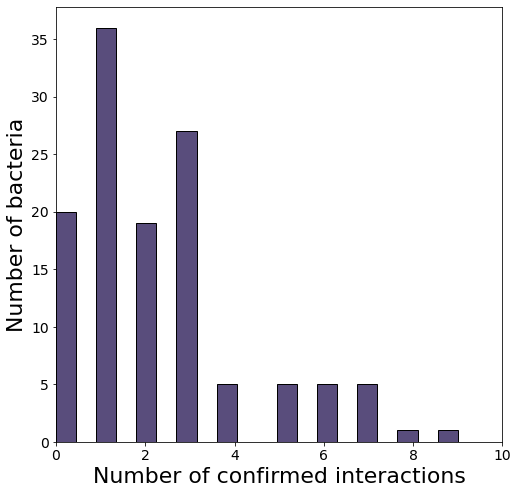

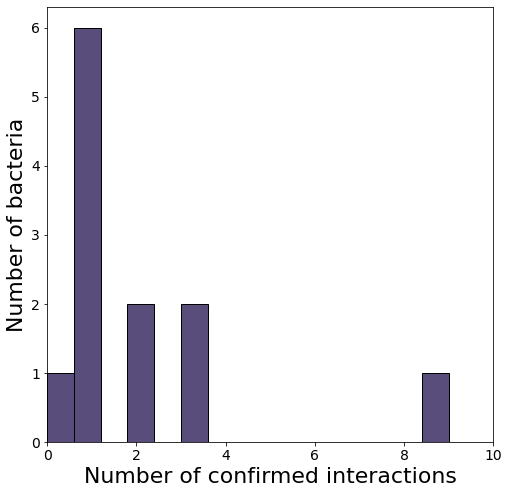

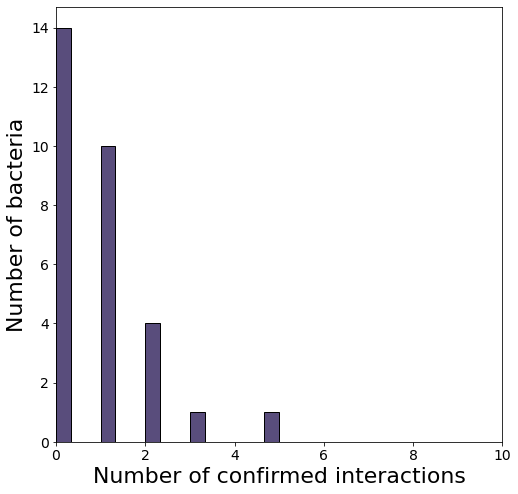

In [24]:
countlist = [countst10, countsmid, countsb10]
binlist = [20, 15, 15]

for i, count in enumerate(countlist):
    fig, ax = plt.subplots(figsize=(8, 8))
    sns.histplot(count, ax=ax, color='#221150', bins=binlist[i])
    ax.set_xlim(0, 10)
    ax.set_xlabel('Number of confirmed interactions', size=22)
    ax.set_ylabel('Number of bacteria', size=22)
    ax.yaxis.set_tick_params(labelsize = 14)
    ax.xaxis.set_tick_params(labelsize = 14)
    fig.savefig(results_path+'/v3.4/ktypecounts_svg'+str(i)+'.svg', format='svg', dpi=400)